# Web Scraping Jazz Standards

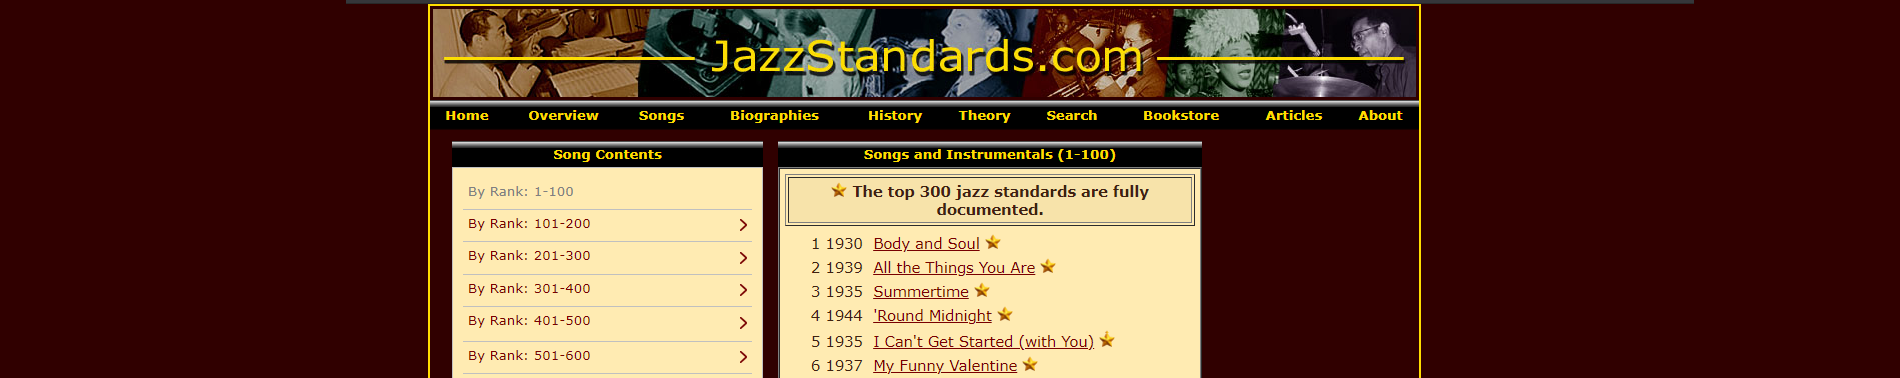

### Importing the libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

### Creating and concatenating the "Rank", "Title", "Year", and "URL" columns

In [2]:
titles = []
years = []
urls = []
ranks = [i for i in range(1, 1001)]

I have defined a *JazzStandardsTable* function that will scrape data from the url given to it as an argument.

By looking at the html documents of the urls, I have realized that at each page, the standards are listed between 25th and 125th 'a' tags. I have written the for loops accordingly.

In [3]:
def JazzStandardsTable(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')

    for i in range(25, 125):
        titles.append(soup.find_all('a')[i].get_text())
    
    for i in range(25, 125):
        urls.append(soup.find_all('a')[i].get('href'))
    
    for i in range(0, 100):
        years.append(soup.find_all('tr', class_='JSContentsLine')[i].get_text().split('\xa0')[0][-4:])

The URLs that I will scrape data from has this structure: ".../index.htm", ".../index2.htm", ".../index3.htm" ... ".../index10.htm".

Therefore, I have written a for loop to place the right number at the end of the word "index" each time JazzStandardsTable function is called.

In [4]:
url = 'https://www.jazzstandards.com/compositions/index.htm'
JazzStandardsTable(url)

for i in range(2, 11):
    index = url.find('index')
    url = url[:index+5] + str(i) + '.htm'
    JazzStandardsTable(url)

Converting python lists into pandas Series, so that I can concatenate them and create the first version of **JazzStandards** DataFrame.

In [5]:
title = pd.Series(titles, name='Title')
year = pd.Series(years, name='Year')
rank = pd.Series(ranks, name='Rank')
url = pd.Series(urls, name='URL')

In [6]:
JazzStandards = pd.concat([rank, title, year, url], axis=1)

In [7]:
JazzStandards

,Rank,Title,Year,URL
0,1,Body and Soul,1930,https://www.jazzstandards.com/compositions-0/b...
1,2,All the Things You Are,1939,https://www.jazzstandards.com/compositions-0/a...
2,3,Summertime,1935,https://www.jazzstandards.com/compositions-0/s...
3,4,'Round Midnight,1944,https://www.jazzstandards.com/compositions-0/r...
4,5,I Can't Get Started (with You),1935,https://www.jazzstandards.com/compositions-0/i...
...,...,...,...,...
995,996,Wives and Lovers (Hey Little Girl),1963,https://www.jazzstandards.com/compositions-9/w...
996,997,This Is All I Ask,1958,https://www.jazzstandards.com/compositions-9/t...
997,998,Doggin' Around,1938,https://www.jazzstandards.com/compositions-9/d...
998,999,I Won't Dance,1935,https://www.jazzstandards.com/compositions-9/i...


### Adding Composer(s) and Lyricist(s) columns

In each of the urls of the jazz standards, there is a table indicating the composer and lyricist. The rest of the code scrapes that data, cleans it, converts it to pandas Series and concatenates them to create the last version of **JazzStandards** DataFrame.

In [8]:
music = []
lyrics = []

In [9]:
for url in urls:
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    music.append(soup.find('table', id='table33').find_all('tr', class_='JSQuote')[-2].get_text().strip().split('\n')[2:])
    lyrics.append(soup.find('table', id='table33').find_all('tr', class_='JSQuote')[-1].get_text().strip().split('\n')[2:])

In [10]:
Music = pd.Series(music, name='Composer(s)')
Lyrics = pd.Series(lyrics, name='Lyricist(s)')

### Cleaning Data

In [11]:
for a in range(len(Lyrics)):
    for b in range(len(Lyrics[a])):
        Lyrics[a][b] = Lyrics[a][b].strip()

In [12]:
for a in range(len(Music)):
    for b in range(len(Music[a])):
        Music[a][b] = Music[a][b].strip()

In some of the jazz standards, the music and lyrics were written by the same person. In the code I have written so far, for those standards, the "Music" Series is an empty list, while the person is available in the "Lyrics" series. Therefore, in the following few cells, I am filling those cells by copying the ones from the "Lyrics" series.

In [13]:
Music = Music.apply(lambda x: np.nan if len(x)==0 else x)

In [14]:
Music.fillna(Lyrics, inplace=True)

In [15]:
for i in range(len(Lyrics)):
    Lyrics[i] = ', '.join(Lyrics[i])

In [16]:
for i in range(len(Lyrics)):
    Music[i] = ', '.join(Music[i])

In [17]:
JazzStandards = pd.concat([JazzStandards, Music, Lyrics], axis=1)

In [18]:
JazzStandards = JazzStandards[['Rank', 'Title', 'Year', 'Composer(s)', 'Lyricist(s)', 'URL']]

In [19]:
JazzStandards.head(60)

,Rank,Title,Year,Composer(s),Lyricist(s),URL
0,1,Body and Soul,1930,Johnny Green,"Edward Heyman, Robert Sour, Frank Eyton",https://www.jazzstandards.com/compositions-0/b...
1,2,All the Things You Are,1939,Jerome Kern,Oscar Hammerstein II,https://www.jazzstandards.com/compositions-0/a...
2,3,Summertime,1935,George Gershwin,DuBose Heyward,https://www.jazzstandards.com/compositions-0/s...
3,4,'Round Midnight,1944,"Cootie Williams, Thelonious Monk",Bernie Hanighen,https://www.jazzstandards.com/compositions-0/r...
4,5,I Can't Get Started (with You),1935,Vernon Duke,Ira Gershwin,https://www.jazzstandards.com/compositions-0/i...
5,6,My Funny Valentine,1937,Richard Rodgers,Lorenz Hart,https://www.jazzstandards.com/compositions-0/m...
6,7,"Lover Man (Oh, Where Can You Be?)",1942,"James Edward Davis, Ram Ramirez, Jimmy Sherman","James Edward Davis, Ram Ramirez, Jimmy Sherman",https://www.jazzstandards.com/compositions-0/l...
7,8,What Is This Thing Called Love?,1930,Cole Porter,Cole Porter,https://www.jazzstandards.com/compositions-0/w...
8,9,Yesterdays,1933,Jerome Kern,Otto Harbach,https://www.jazzstandards.com/compositions-0/y...
9,10,Stella By Starlight,1946,Victor Young,Ned Washington,https://www.jazzstandards.com/compositions-0/s...


In [20]:
JazzStandards.to_csv("JazzStandards.csv", header=True, index=False)